In [6]:
""" Import_libraries"""
# Load libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import numpy as np
from scipy.stats import norm
import time
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem
from keras import models
from keras import optimizers
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

# Set random seed
# fix random seed for reproducibility
np.random.seed(7)

In [7]:
""" Read csv file and return it as a panda dataframe(dictionary) """
def read_csv(path):
    """ Read csv, return a panda dataframe(dictionary) """
    df = pd.read_csv(path)
    return df

In [8]:
"""Load chemicals information and convert the chemical info to SMILES format """
def load_chemicals(path):
    
    SolubilityData = read_csv(path) # read csv
    
    chems=[] # variable to store the 
    
#     print("List loaded:\n") # view the list
#     print(SolubilityData)
    
    # change column names of 
    SolubilityData.rename(columns={ SolubilityData.columns[1]: "Solubility" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[0]: "Compound" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[2]: "SMILES" }, inplace=True)
    
    for row in range(0,len(SolubilityData['SMILES'])):
        chems.append( Chem.MolFromSmiles(SolubilityData['SMILES'][row] ) )
    SolubilityData['SMILES'] = chems
    return SolubilityData # return the data list which contains the three input

#     chems = SolubilityData['SMILES'] # read columns
#     compounds =  SolubilityData['Compound ID']
#     solubilities = SolubilityData['measured log(solubility:mol/L)']
    
#     data = {"chems": chems,
#             "compounds": compounds,
#             "solubilities": solubilities,


data = load_chemicals("C:/Users/DR/Desktop/P2/Latent-master/data/solubility/delaney.csv")

In [9]:
"""Convert SMILES into fingerprint"""
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH=1, MAX_PATH=5):
    fpix = AllChem.RDKFingerprint(chem, minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)    
    fpix = [int(x) for x in list(fpix.ToBitString())]
    return fpix

""" Encode a chemical as a tensor by concatenating fingerprints up to desired depth """
def tensorChem(chems, FINGERPRINT_SIZE, CHEMDEPTH):
    TRAIN_BATCH_SIZE = len(chems)   
    Xs = np.zeros( (TRAIN_BATCH_SIZE, FINGERPRINT_SIZE, CHEMDEPTH) )
    # print(Xs.shape)
    for i in range(0, len(chems)-1):
        for k in range(0, CHEMDEPTH):
            fpix = chemFP(chems[i],FINGERPRINT_SIZE, k+1, k+1)
            Xs[i, :, k] = fpix
    return Xs

In [10]:
""" Flatten the tensor into a two dimentional vector(feature mapping) """
# The original vector shape
depth = 4
train_y_b4=np.zeros((1,len(data['Solubility'])))
fpSize = 1024
tc = tensorChem(data['SMILES'],fpSize, depth)
print('The original vector shape:\n'+str(tc.shape))
# The flattened vector shape
train_x_flatten = tc.reshape(tc.shape[0], -1).T
print('The flattened vector shape:\n '+str(train_x_flatten.shape))
# The shape of label vector
train_y_b4[0]=np.squeeze(data['Solubility'])
print('The solubility vector shape:\n '+str(train_y_b4.shape))

The original vector shape:
(1144, 1024, 4)
The flattened vector shape:
 (4096, 1144)
The solubility vector shape:
 (1, 1144)


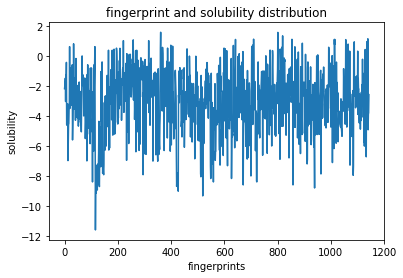

The mean of the solubility is: -3.0579973776223777
The S.D. of the solubility is: 2.0955854254462576


C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


'In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function \nof a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population\nare made, based on a finite data sample.'

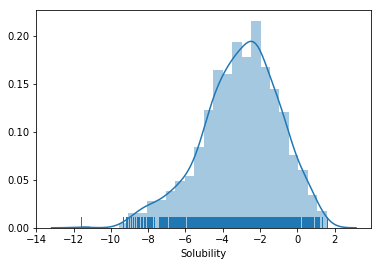

In [11]:
""" Visualize solubility """
# plot the solubility distribution
plt.plot(np.squeeze(train_y_b4))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution" )
plt.show()

# plot the histogram of solubility
import seaborn as sns
train_y_plot = pd.Series( np.squeeze(train_y_b4), name="Solubility")
mean = train_y_b4.mean()
std = train_y_b4.std()
print("The mean of the solubility is: " + str(mean))
print("The S.D. of the solubility is: " + str(std))
sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
"""In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function 
of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population
are made, based on a finite data sample."""

There are 606 soluble chemicals (positive samples) and 538 insoluble chemicals (negative samples).


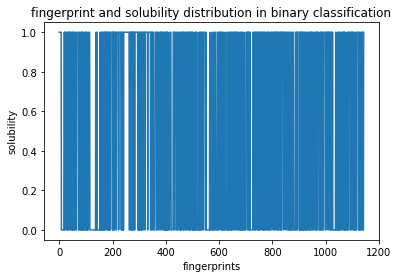

In [14]:
""" Hardmax the labels """
# convert train_y into a vector range from 0 to 1
train_y=np.zeros((1,len(data['Solubility'])))
for i in range(0,len(train_y_b4[0])):
    if (train_y_b4[0][i] >=mean):
        train_y[0][i]=1
    else:
        train_y[0][i]=0

print('There are '+ str(list(np.squeeze(train_y)).count(1)) + ' soluble chemicals (positive samples) and ' + str(list(np.squeeze(train_y)).count(0)) + ' insoluble chemicals (negative samples).')
        
# plot the input fingerprint length distribution plot
plt.plot(np.squeeze(train_y))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution in binary classification" )
plt.show()


In [25]:
data.drop(['Solubility', 'SMILES'], axis=1)

,Compound,Solu
0,"1,1,1,2-Tetrachloroethane",1.0
1,"1,1,1-Trichloroethane",1.0
2,"1,1,2,2-Tetrachloroethane",1.0
3,"1,1,2-Trichloroethane",1.0
4,"1,1,2-Trichlorotrifluoroethane",1.0
5,"1,1-Dichloroethane",1.0
6,"1,1-Dichloroethylene",1.0
7,"1,1-Diethoxyethane",1.0
8,"1,2,3,4-Tetrachlorobenzene",0.0
9,"1,2,3,4-Tetrahydronapthalene",0.0


In [8]:
"""This initially creates clusters of points normally distributed (std=1) about vertices of an n_informative-dimensional hypercube with sides of length 2*class_sep and assigns an equal number of clusters to each class. It introduces interdependence between these features and adds various types of further noise to the data."""
# Number of features
number_of_features = 4096
# Generate features matrix and target vector
features, target = make_classification(n_samples = 1144,
                                       n_features = number_of_features,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 2,
                                       weights = [.5, .5],
                                       random_state = 0)

In [9]:
#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations))
def create_network():
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=20, activation='relu', input_shape=(number_of_features,)))
    
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=7, activation='relu'))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=5, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))
    
    # Setup hyperparameters for Adam optimizer
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    
    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer= Adam, # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
  
    # Return compiled network
    return network

In [12]:
# Wrap Keras model so it can be used by scikit-learn
neural_network_Adam = KerasClassifier(build_fn=create_network, 
                                 epochs=5000, 
                                 batch_size=100, 
                                 verbose=0)

neural_network_Adam_batchGD = KerasClassifier(build_fn=create_network, 
                                 epochs=5000, 
                                 batch_size=1144, 
                                 verbose=0)

In [11]:
# Prediction of accuracy in folds of 3
cross_val_score(neural_network_Adam,train_x_flatten.T, train_y.T, cv=3)

array([0.7722513 , 0.75328083, 0.76377952])

In [13]:
# Prediction of accuracy in folds of 3 with batch gredient descent
cross_val_score(neural_network_Adam_batchGD,train_x_flatten.T, train_y.T, cv=3)

array([0.7801047 , 0.79002625, 0.77952754])